In [1]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Reshape, Flatten, Conv2D, Conv2DTranspose, LeakyReLU, BatchNormalization
from tensorflow.keras.optimizers import Adam


2023-12-19 20:29:07.438852: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-12-19 20:29:07.513800: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-12-19 20:29:07.513851: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-12-19 20:29:07.513908: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-12-19 20:29:07.529640: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-12-19 20:29:07.530738: I tensorflow/core/platform/cpu_feature_guard.cc:182] This Tens

# Load Data

In [2]:
import os
import numpy as np


def load_data(folder):
    data = []
    labels = []
    for subfolder in os.listdir(folder):
        subfolder_path = os.path.join(folder, subfolder)
        if os.path.isdir(subfolder_path):
            for file in os.listdir(subfolder_path):
                file_path = os.path.join(subfolder_path, file)
                if file.endswith('.npy'):
                    # Load numpy array
                    array = np.load(file_path).flatten()
                    data.append(array)
                    # Label phishing as 1, benign as 0
                    label = 1 if (folder.find('phishing') != -1) else 0
                    labels.append(label)
    return np.array(data), np.array(labels)

# Đường dẫn đến thư mục chứa dữ liệu
phishing_path = 'VisualPhish/phishing_features'
benign_path = 'VisualPhish/trusted_list_features'

# Load dữ liệu
phishing_data, phishing_labels = load_data(phishing_path)
benign_data, benign_labels = load_data(benign_path)



# DCGAN

In [3]:
def build_generator(noise_dim):
    model = tf.keras.Sequential([
        Dense(256, input_shape=(noise_dim,)),
        LeakyReLU(alpha=0.2),
        Dense(512),  # Tăng số lượng neuron
        LeakyReLU(alpha=0.2),
        Dense(1024),  # Tăng thêm số lượng neuron
        LeakyReLU(alpha=0.2),
        Dense(512)  # Output layer với 512 units
    ])
    return model

def build_discriminator():
    model = tf.keras.Sequential([
        Dense(1024, input_shape=(512,)),
        LeakyReLU(alpha=0.2),
        Dense(512),  # Giảm số lượng neuron
        LeakyReLU(alpha=0.2),
        Dense(256),  # Giảm thêm số lượng neuron
        LeakyReLU(alpha=0.2),
        Dense(1, activation='sigmoid')  # Output layer
    ])
    return model

In [4]:
def build_gan(generator, discriminator):
    model = Sequential()

    model.add(generator)
    model.add(discriminator)

    return model

z_dim = 100
batch_size = 32
learning_rate = 0.0002

discriminator = build_discriminator()
discriminator.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate), metrics=['accuracy'])

generator = build_generator(z_dim)

discriminator.trainable = False
gan = build_gan(generator, discriminator)
gan.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate))


In [5]:
generator.summary()
discriminator.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_4 (Dense)             (None, 256)               25856     
                                                                 
 leaky_re_lu_3 (LeakyReLU)   (None, 256)               0         
                                                                 
 dense_5 (Dense)             (None, 512)               131584    
                                                                 
 leaky_re_lu_4 (LeakyReLU)   (None, 512)               0         
                                                                 
 dense_6 (Dense)             (None, 1024)              525312    
                                                                 
 leaky_re_lu_5 (LeakyReLU)   (None, 1024)              0         
                                                                 
 dense_7 (Dense)             (None, 512)              

In [6]:
def train_gan(gan, generator, discriminator, dataset, z_dim, epochs=100):
    for epoch in range(epochs):
        for real_images in dataset:
            # Điều chỉnh kích thước của z dựa trên kích thước thực tế của real_images
            current_batch_size = real_images.shape[0]
            z = np.random.normal(0, 1, (current_batch_size, z_dim))
            fake_images = generator.predict(z, verbose=0)

            combined_images = np.concatenate([real_images, fake_images])
            labels = np.concatenate([np.ones((current_batch_size, 1)), np.zeros((current_batch_size, 1))])
            labels += 0.05 * np.random.random(labels.shape)

            d_loss = discriminator.train_on_batch(combined_images, labels)

            z = np.random.normal(0, 1, (current_batch_size, z_dim))
            fake_labels = np.ones((current_batch_size, 1))

            g_loss = gan.train_on_batch(z, fake_labels)

        print(f"Epoch: {epoch + 1}, D Loss: {d_loss[0]}, G Loss: {g_loss}")

# Chia dataset thành các batch
dataset = [phishing_data[i:i + batch_size] for i in range(0, len(phishing_data), batch_size)]
if len(dataset[-1]) != batch_size:
    dataset.pop()  # Xóa batch cuối nếu kích thước không phù hợp

# Khởi tạo và huấn luyện mô hình GAN
#train_gan(gan, generator, discriminator, dataset, z_dim, 1000)

# Tái tạo kiến trúc mô hình
generator = build_generator(z_dim)
discriminator = build_discriminator()

# Tải trọng số
generator.load_weights('generator_weights_gan.h5')
discriminator.load_weights('discriminator_weights_gan.h5')
"""

generator.save_weights('generator_weights_gan.h5')
discriminator.save_weights('discriminator_weights_gan.h5')

"""


"\n\ngenerator.save_weights('generator_weights_gan.h5')\ndiscriminator.save_weights('discriminator_weights_gan.h5')\n\n"

In [7]:
import matplotlib.pyplot as plt
import numpy as np

def showFeature(features):
  image = features.reshape(16, 32)
  #print(image.shape)
  #print(image)
  
  plt.subplot(1, 1, 1)  # Tạo subplot
  plt.imshow(image, cmap='viridis')  # Sử dụng viridis làm bảng màu
  plt.title(f'Feature map')
  plt.axis('off')  # Ẩn trục tọa độ

  plt.show()

================ 0 =================
Fake:


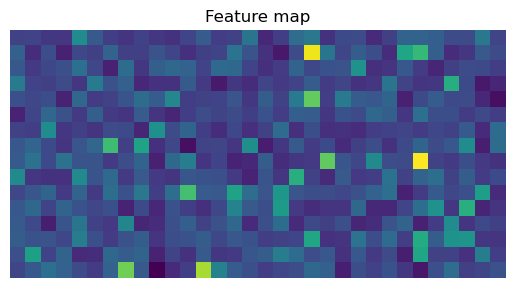

Real:


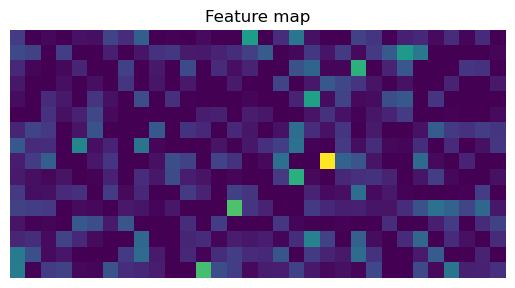

================ 1 =================
Fake:


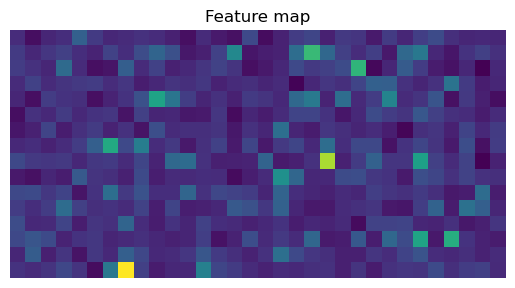

Real:


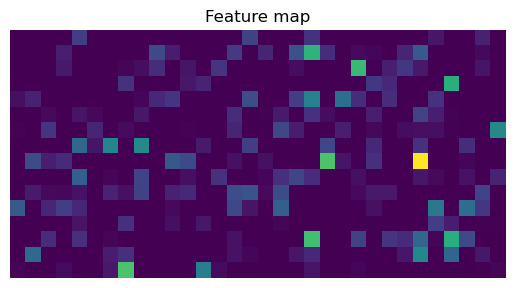

================ 2 =================
Fake:


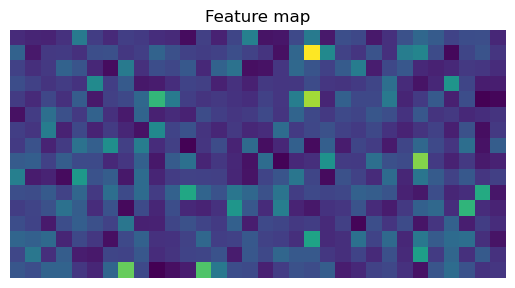

Real:


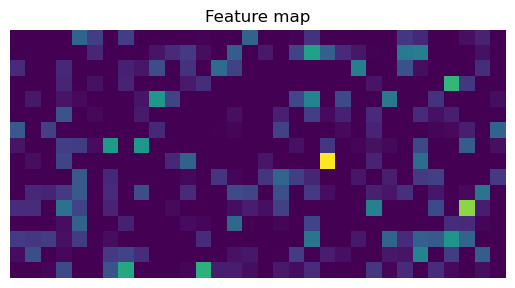

================ 3 =================
Fake:


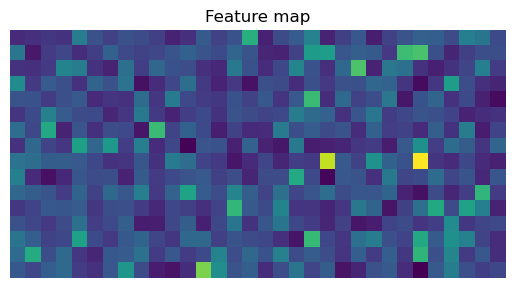

Real:


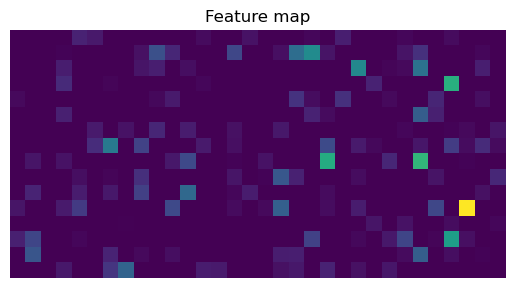

================ 4 =================
Fake:


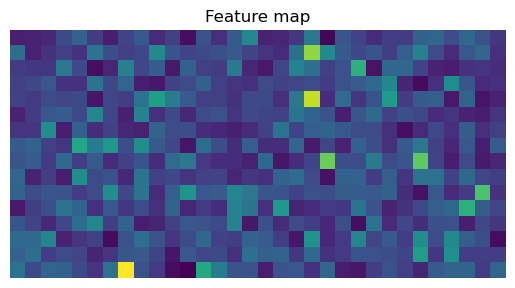

Real:


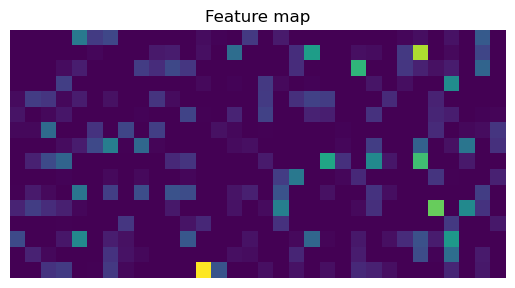

================ 5 =================
Fake:


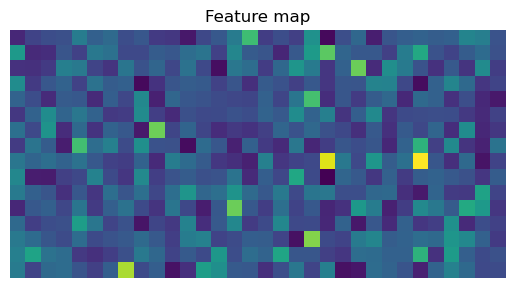

Real:


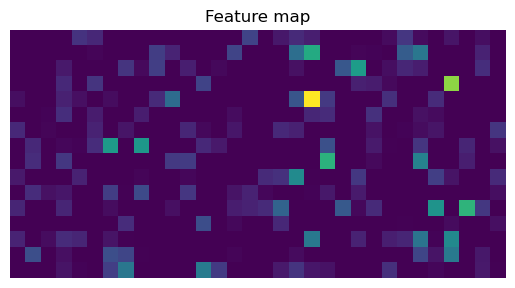

================ 6 =================
Fake:


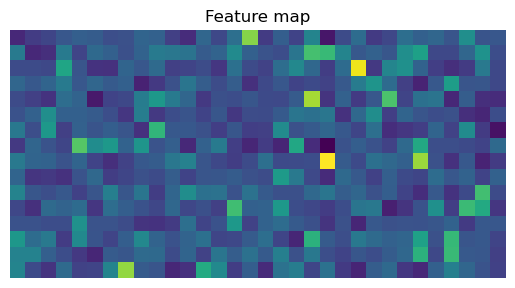

Real:


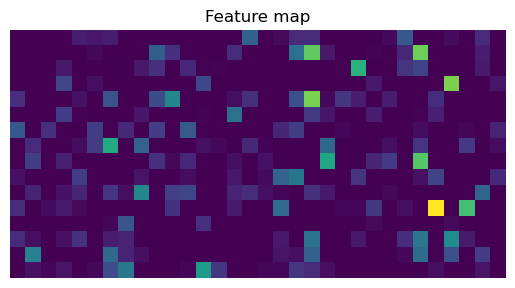

================ 7 =================
Fake:


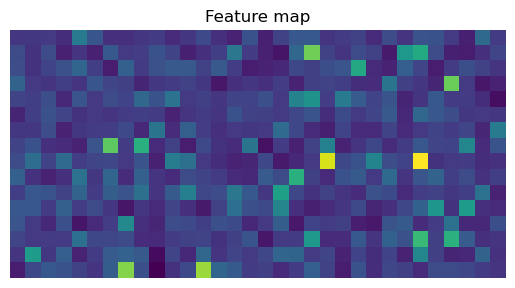

Real:


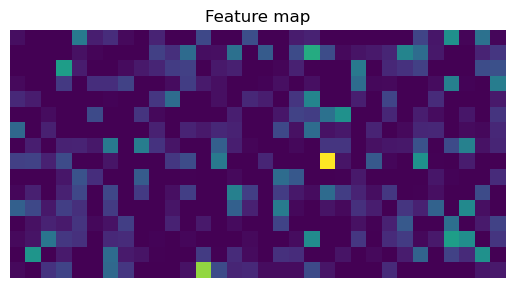

================ 8 =================
Fake:


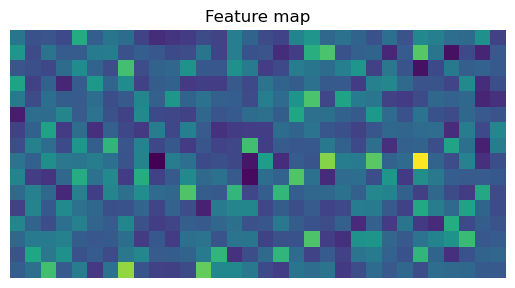

Real:


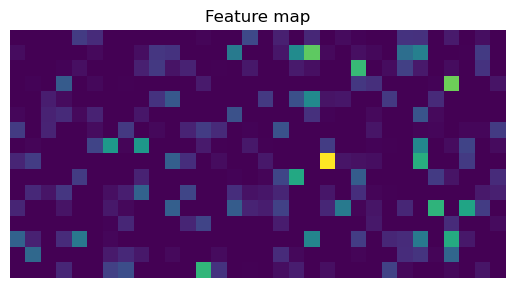

================ 9 =================
Fake:


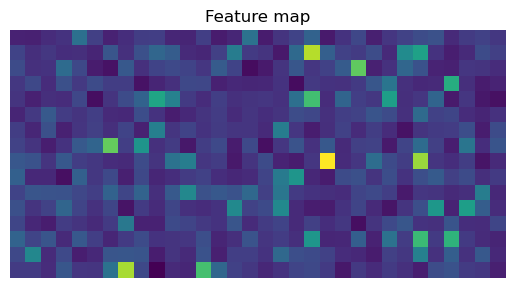

Real:


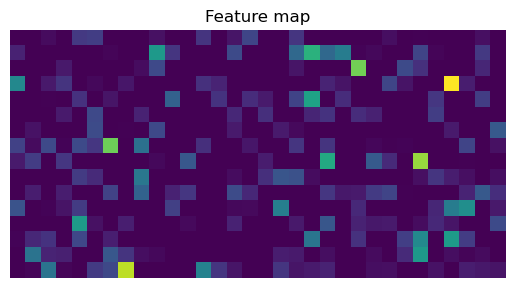

In [8]:
z = np.random.normal(0, 1, (10, z_dim))
fake_images = generator.predict(z, verbose=0)
for i in range(10):
  print("================", i, "=================")
  print("Fake:")
  showFeature(fake_images[i])
  print("Real:")
  showFeature(dataset[0][i])

In [9]:
"""
@tf.function
def train_step(images, z_dim, discriminator, generator, discriminator_optimizer, generator_optimizer):
    # Tạo nhiễu ngẫu nhiên
    noise = tf.random.normal([batch_size, z_dim])

    # GradientTape cho discriminator
    with tf.GradientTape() as disc_tape:
        generated_images = generator(noise, training=True)

        real_output = discriminator(images, training=True)
        fake_output = discriminator(generated_images, training=True)

        disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

    # GradientTape cho generator
    with tf.GradientTape() as gen_tape:
        generated_images = generator(noise, training=True)
        fake_output = discriminator(generated_images, training=True)
        gen_loss = generator_loss(fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    """


'\n@tf.function\ndef train_step(images, z_dim, discriminator, generator, discriminator_optimizer, generator_optimizer):\n    # Tạo nhiễu ngẫu nhiên\n    noise = tf.random.normal([batch_size, z_dim])\n\n    # GradientTape cho discriminator\n    with tf.GradientTape() as disc_tape:\n        generated_images = generator(noise, training=True)\n\n        real_output = discriminator(images, training=True)\n        fake_output = discriminator(generated_images, training=True)\n\n        disc_loss = discriminator_loss(real_output, fake_output)\n\n    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)\n    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))\n\n    # GradientTape cho generator\n    with tf.GradientTape() as gen_tape:\n        generated_images = generator(noise, training=True)\n        fake_output = discriminator(generated_images, training=True)\n        gen_loss = generator_loss(fak

In [10]:
print(benign_data.shape)
print(phishing_data.shape)

(9363, 512)
(1195, 512)


In [11]:
while (len(phishing_data) < len(benign_data)):
  print(len(phishing_data), "/", len(benign_data))
  z = np.random.normal(0, 1, (1, z_dim))
  gen_img = generator.predict(z, verbose=0)

  phishing_data = np.vstack((phishing_data, gen_img[0]))
  phishing_labels = np.append(phishing_labels, 1)

print(phishing_data.shape)
print(benign_data.shape)
# Gộp dữ liệu và labels
X = np.concatenate((phishing_data, benign_data), axis=0)
y = np.concatenate((phishing_labels, benign_labels), axis=0)

1195 / 9363
1196 / 9363
1197 / 9363
1198 / 9363
1199 / 9363
1200 / 9363
1201 / 9363
1202 / 9363
1203 / 9363
1204 / 9363
1205 / 9363
1206 / 9363
1207 / 9363
1208 / 9363
1209 / 9363
1210 / 9363
1211 / 9363
1212 / 9363
1213 / 9363
1214 / 9363
1215 / 9363
1216 / 9363
1217 / 9363
1218 / 9363
1219 / 9363
1220 / 9363
1221 / 9363
1222 / 9363
1223 / 9363
1224 / 9363
1225 / 9363
1226 / 9363
1227 / 9363
1228 / 9363
1229 / 9363
1230 / 9363
1231 / 9363
1232 / 9363
1233 / 9363
1234 / 9363
1235 / 9363
1236 / 9363
1237 / 9363
1238 / 9363
1239 / 9363
1240 / 9363
1241 / 9363
1242 / 9363
1243 / 9363
1244 / 9363
1245 / 9363
1246 / 9363
1247 / 9363
1248 / 9363
1249 / 9363
1250 / 9363
1251 / 9363
1252 / 9363
1253 / 9363
1254 / 9363
1255 / 9363
1256 / 9363
1257 / 9363
1258 / 9363
1259 / 9363
1260 / 9363
1261 / 9363
1262 / 9363
1263 / 9363
1264 / 9363
1265 / 9363
1266 / 9363
1267 / 9363
1268 / 9363
1269 / 9363
1270 / 9363
1271 / 9363
1272 / 9363
1273 / 9363
1274 / 9363
1275 / 9363
1276 / 9363
1277 / 9363
1278

2023-12-19 20:37:36.470974: W tensorflow/core/data/root_dataset.cc:297] Optimization loop failed: CANCELLED: Operation was cancelled


7303 / 9363
7304 / 9363
7305 / 9363
7306 / 9363
7307 / 9363
7308 / 9363
7309 / 9363
7310 / 9363
7311 / 9363
7312 / 9363
7313 / 9363
7314 / 9363
7315 / 9363
7316 / 9363
7317 / 9363
7318 / 9363
7319 / 9363
7320 / 9363
7321 / 9363
7322 / 9363
7323 / 9363
7324 / 9363
7325 / 9363
7326 / 9363
7327 / 9363
7328 / 9363
7329 / 9363
7330 / 9363
7331 / 9363
7332 / 9363
7333 / 9363
7334 / 9363
7335 / 9363
7336 / 9363
7337 / 9363
7338 / 9363
7339 / 9363
7340 / 9363
7341 / 9363
7342 / 9363
7343 / 9363
7344 / 9363
7345 / 9363
7346 / 9363
7347 / 9363
7348 / 9363
7349 / 9363
7350 / 9363
7351 / 9363
7352 / 9363
7353 / 9363
7354 / 9363
7355 / 9363
7356 / 9363
7357 / 9363
7358 / 9363
7359 / 9363
7360 / 9363
7361 / 9363
7362 / 9363
7363 / 9363
7364 / 9363
7365 / 9363
7366 / 9363
7367 / 9363
7368 / 9363
7369 / 9363
7370 / 9363
7371 / 9363
7372 / 9363
7373 / 9363
7374 / 9363
7375 / 9363
7376 / 9363
7377 / 9363
7378 / 9363
7379 / 9363
7380 / 9363
7381 / 9363
7382 / 9363
7383 / 9363
7384 / 9363
7385 / 9363
7386

# DNN

In [12]:

def create_model():
    DNN_model = Sequential([
        Dense(1024, activation='relu', input_shape=(512,)),
        Dense(512, activation='relu'),
        Dense(256, activation='relu'),
        Dense(128, activation='relu'),
        Dense(64, activation='relu'),
        Dense(1, activation='sigmoid')
    ])
    return DNN_model

In [13]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=75)

# Chia dữ liệu thành 10 phần

federated_data = []

# Giả sử X, y là dữ liệu của bạn
num_clients = 3

num_samples_per_client = len(X_train) // num_clients

for i in range(num_clients):
    start_idx = i * num_samples_per_client
    end_idx = (i + 1) * num_samples_per_client if i != num_clients - 1 else len(X_train)
    
    X_client = X_train[start_idx:end_idx]
    y_client = y_train[start_idx:end_idx]

    federated_data.append((X_client, y_client))



In [14]:
def preprocessing(X_data, y_data):
    # Chuyển đổi sang TensorFlow Dataset
    dataset = tf.data.Dataset.from_tensor_slices((X_data, y_data))
    dataset = dataset.batch(32) # BatchSize
    return dataset

In [15]:
federated_data_train = [preprocessing(X_client, y_client) for X_client, y_client in federated_data]

In [16]:
import tensorflow_federated as tff
print(tff.__version__)


0.67.0


In [17]:
input_spec = (
    tf.TensorSpec(shape=[None, 512], dtype=tf.float32),  # None is for the batch size
    tf.TensorSpec(shape=[None], dtype=tf.int64),  # Assuming y_client is an integer label
)


In [18]:
def client_optimizer_fn():
    return tf.keras.optimizers.Adam(learning_rate=0.001)

def server_optimizer_fn():
    return tf.keras.optimizers.Adam(learning_rate=0.001)

In [20]:
import tensorflow_federated as tff
from tensorflow_privacy.privacy.dp_query import gaussian_query

def model_fn():
    keras_model = create_model()
    return tff.learning.models.from_keras_model(
        keras_model,
        input_spec=input_spec,
        loss=tf.keras.losses.BinaryCrossentropy(),
        metrics=[tf.keras.metrics.BinaryAccuracy()])

# Cấu hình cho Differential Privacy
l2_norm_clip = 1.0
noise_multiplier = 1.0
num_microbatches = 1  # Có thể điều chỉnh tùy vào kích thước dữ liệu

# Tạo DPQuery
dp_query = gaussian_query.GaussianSumQuery(l2_norm_clip, l2_norm_clip * noise_multiplier)

# Tạo một aggregation process với DP
dp_aggregate_fn = tff.learning.models.dp_aggregator(
    dp_query, num_microbatches=num_microbatches)

iterative_process = tff.learning.algorithms.build_weighted_fed_avg(
    model_fn=model_fn,
    client_optimizer_fn=client_optimizer_fn,
    server_optimizer_fn=server_optimizer_fn,
    model_update_aggregation_factory=dp_aggregate_fn
)
state = iterative_process.initialize()

AttributeError: module 'tensorflow_federated.python.learning.models' has no attribute 'dp_aggregator'

In [ ]:
ROUNDS = 100

In [ ]:
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score

def evaluate_model(model, X_test, y_test):
    y_pred_proba = model.predict(X_test).flatten()
    y_pred = (y_pred_proba > 0.5).astype(int)  # Giả sử đây là bài toán phân loại nhị phân

    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    auc = roc_auc_score(y_test, y_pred_proba)

    return precision, recall, f1, auc


In [ ]:
for round_num in range(1, ROUNDS + 1):
    state, metrics = iterative_process.next(state, federated_data_train)
    print('Round {:2d}, Metrics: {}'.format(round_num, metrics))
    
    # Tạo và cập nhật mô hình toàn cầu
    global_model = create_model()
    global_model.compile(
        optimizer=client_optimizer_fn(), 
        loss='binary_crossentropy', 
        metrics=['accuracy']
    )
        # Get model weights
    model_weights = iterative_process.get_model_weights(state)

    # Set the weights to your Keras model
    global_model.set_weights(model_weights.trainable)

    # Đánh giá mô hình toàn cầu
    precision, recall, f1, auc = evaluate_model(global_model, X_test, y_test)
    print(f'Round {round_num}: Global Model - Precision={precision}, Recall={recall}, F1={f1}, AUC={auc}')
    print()
    print()
    

In [ ]:
dt_test = preprocessing(X_client, y_client)

In [ ]:
global_model = create_model()
global_model.compile(
    optimizer=client_optimizer_fn(), 
    loss='binary_crossentropy', 
    metrics=['accuracy']
)
    # Get model weights
model_weights = iterative_process.get_model_weights(state)

# Set the weights to your Keras model
global_model.set_weights(model_weights.trainable)
y_pred_proba = global_model.predict(X_train).flatten()
print(y_test)
print(y_pred_proba)

In [ ]:
cnt = 0
for i in y_pred_proba:
  if i != 1.0:
    cnt += 1

print(cnt)

In [ ]:
test = tf.data.Dataset.from_tensor_slices((X_test, y_test))
test = test.batch(32)
result = global_model.evaluate(test)
dict(zip(global_model.metrics_names, result))